This notebook contains SOTIP's spatial heterogeneity quantification module using a 4i HeLa dataset. For the steps, please refer to the table of contents automatically generated by jupyterlab on the left side bar.

author: Zhiyuan Yuan

# imports

In [1]:
from sotip import *
import squidpy as sq


# data loading and processing steps

## load data

In [2]:
adata = sq.datasets.four_i()


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata

AnnData object with n_obs × n_vars = 270876 × 43
    obs: 'x', 'y', 'is_nucleous', 'is_cytplasm', 'cell_id', 'leiden', 'cluster'
    uns: 'cluster_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

the original data contains precomputed umap and leiden, and nuclei/cytplasm annotations

# SOTIP steps

## step 1: each ME is associated with its center cell

In [4]:
knn = 10
spatial_var='spatial'
cls_key='leiden'
ME_var_names_np_unique = np.array(adata.obs[cls_key].cat.categories)

MED(adata,use_cls=cls_key,nn=knn,copy=False,ME_var_names_np_unique=ME_var_names_np_unique,spatial_var=spatial_var) 
  


knn search time cost 0.9332666397094727 s
0 MEs,time cost 4.291534423828125e-06 s, 270876 MEs, 0.0011624736785888672s left
1000 MEs,time cost 0.15159058570861816 s, 269876 MEs, 40.910660908699036s left
2000 MEs,time cost 0.17588329315185547 s, 268876 MEs, 47.29079632949829s left
3000 MEs,time cost 0.13944721221923828 s, 267876 MEs, 37.354561420440675s left
4000 MEs,time cost 0.16622161865234375 s, 266876 MEs, 44.36056069946289s left
5000 MEs,time cost 0.14436054229736328 s, 265876 MEs, 38.38200354385376s left
6000 MEs,time cost 0.19692206382751465 s, 264876 MEs, 52.15992857837677s left
7000 MEs,time cost 0.19857168197631836 s, 263876 MEs, 52.398301153182985s left
8000 MEs,time cost 0.1681656837463379 s, 262876 MEs, 44.20672228050232s left
9000 MEs,time cost 0.15035271644592285 s, 261876 MEs, 39.37376797199249s left
10000 MEs,time cost 0.14450526237487793 s, 260876 MEs, 37.697954827308656s left
11000 MEs,time cost 0.19835352897644043 s, 259876 MEs, 51.547321696281436s left
12000 MEs,tim

array([[ 0.,  7.,  3., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       ...,
       [ 0.,  1.,  5., ...,  0.,  0.,  0.],
       [ 9.,  0.,  0., ...,  0.,  0.,  0.],
       [ 3.,  0.,  0., ...,  0.,  0.,  0.]])

## step 2: Connectivity guided minimum graph distance (CGMGD)

### step 2.1 topological structure is computed with paga

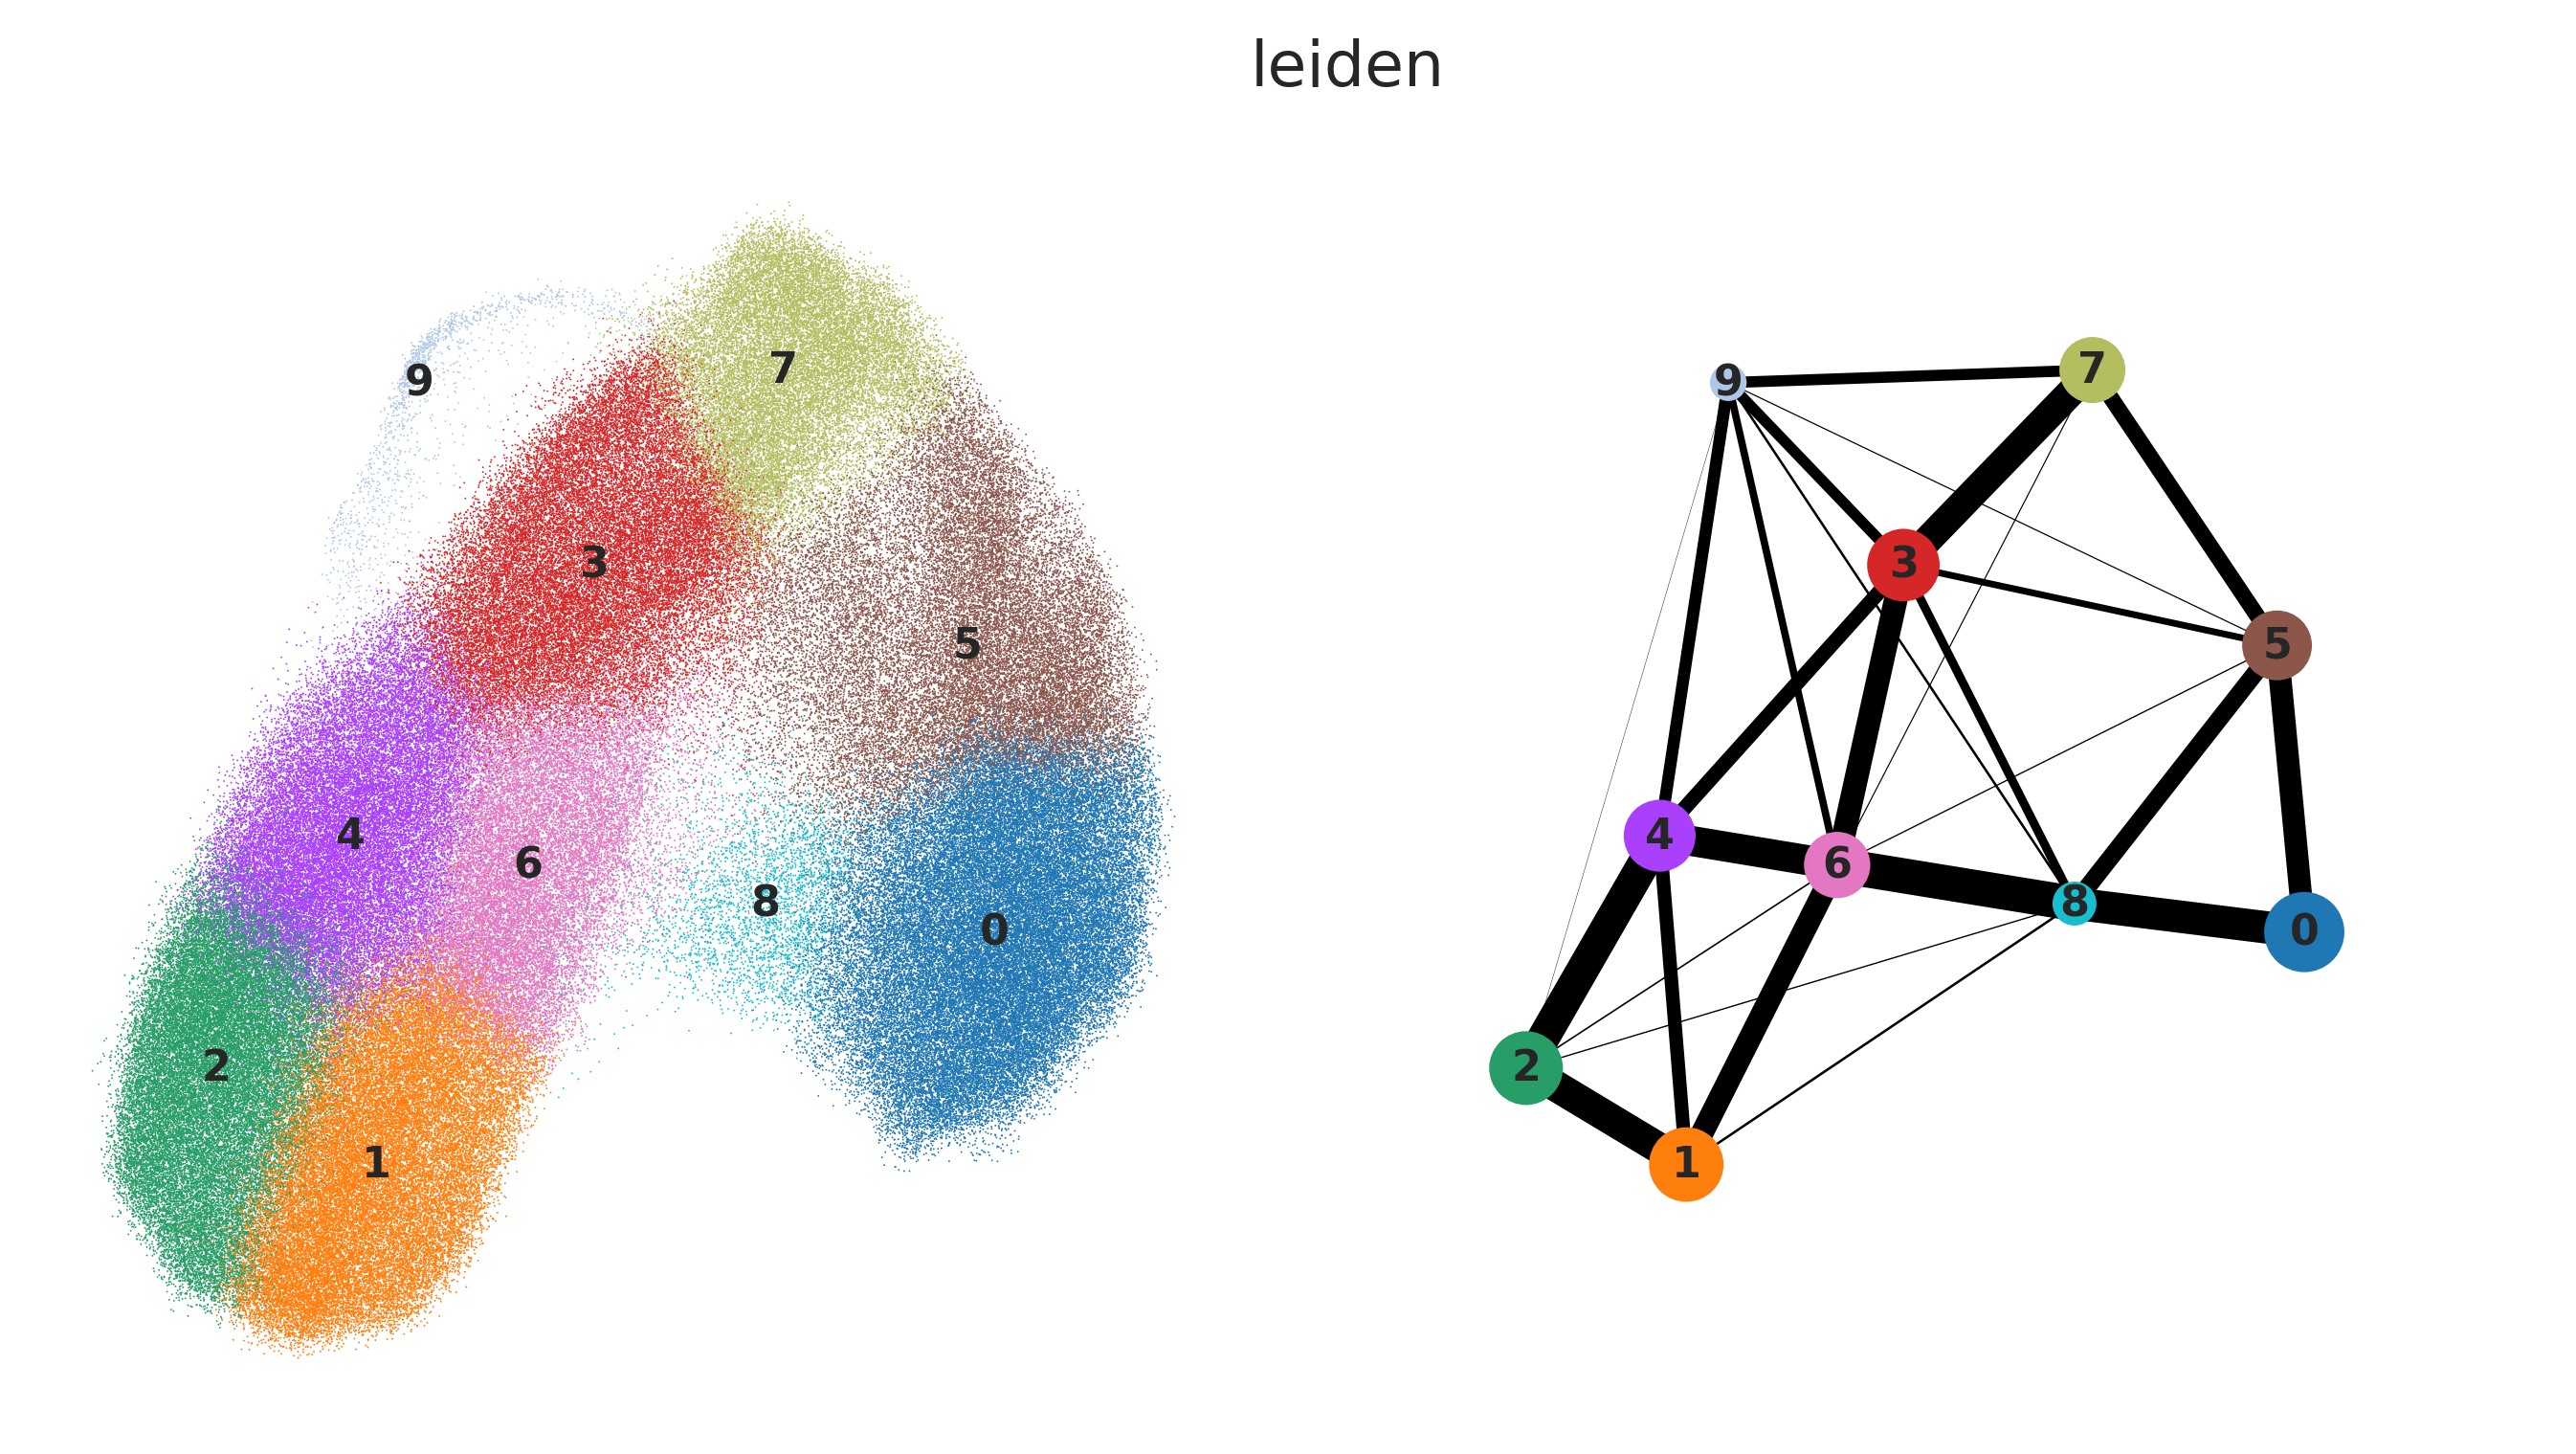

In [5]:
sc.tl.paga(adata,groups=cls_key)
sc.pl.paga_compare(adata,basis='X_umap')

### step 2.2 the connectivities between cell clusters is used to guide the graph distance computation

In [6]:
gd_method = 'paga_guided_umap'
gd = get_ground_distance(adata,method=gd_method,cls_key=cls_key,embed_key=None)  


### step 2.3 compute SHN

In [7]:
heter_key = 'ME_heter_{0}_{1}'.format(cls_key,gd_method)

cal_ME_heterogeneity(adata,copy=False,key_added=heter_key) 

### step 2.4 plot

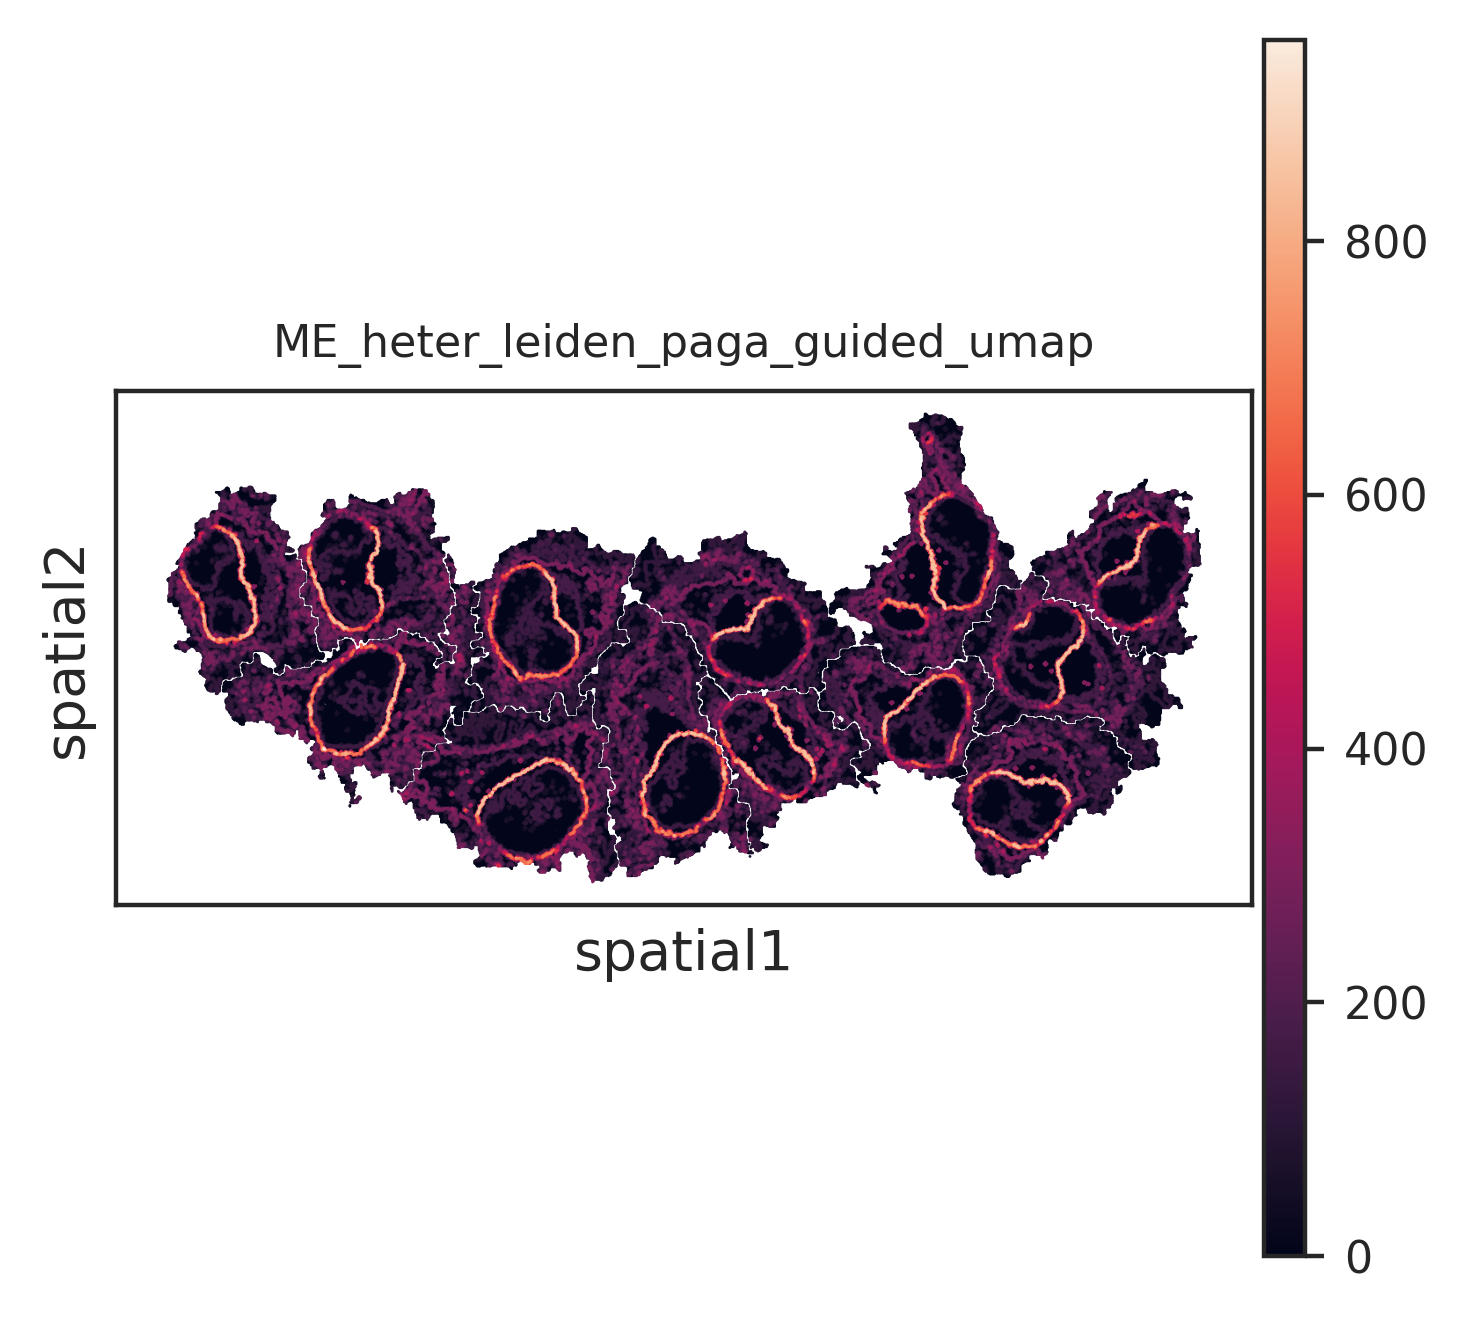

In [8]:
sc.pl.embedding(adata,basis='spatial',color=[heter_key],show=False,size=1,marker='.')
plt.gca().set_aspect('equal', adjustable='box') 


/root/anaconda3/envs/SOTIP/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'is_nucleous' as categorical


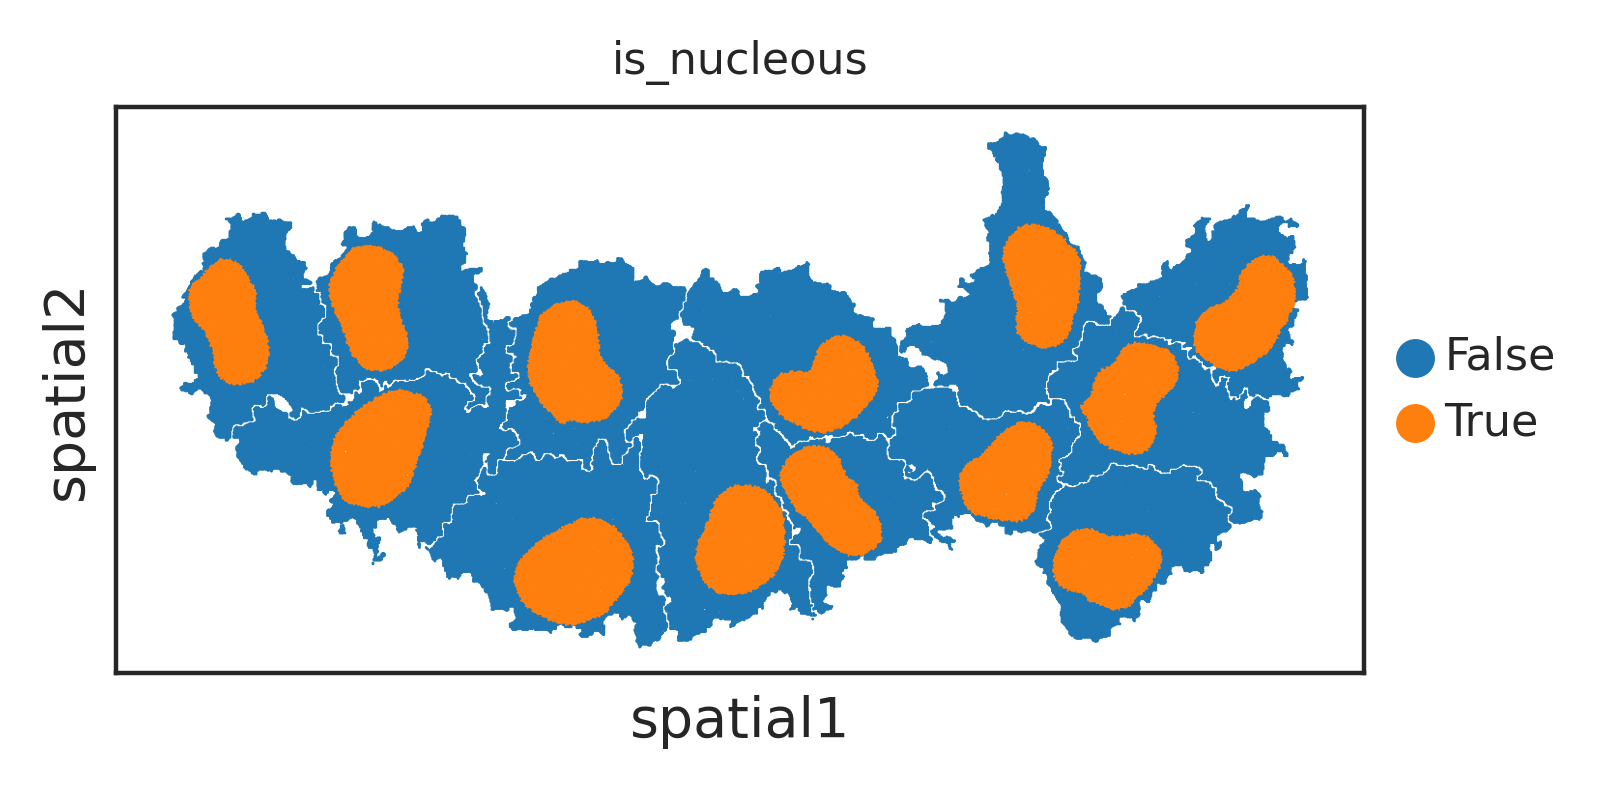

In [9]:
# nucleus annotation
adata.obs['is_nucleous'] = adata.obs['is_nucleous'].astype('str')
sc.pl.embedding(adata,basis='spatial',color=['is_nucleous'],show=False,size=1,marker='.')
plt.gca().set_aspect('equal', adjustable='box') 
